# (20.0) Описание решаемой задачи

Анализ присутствия скрытого объема внутри дня

# (20.1) Установка необходимых пакетов¶

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

# (15.2) Определение функций

In [4]:
# перевод времени в формат datetime
def ReverseToDateTime(t):
    format = '%Y%m%d%H%M%S%f'
    time_str = dt.datetime.strptime(t,format)
    return time_str

# (20.3) Список всех использующихся датафреймов¶¶

In [ ]:
# orders - ордерлог на заданную дату
# chain_results - список всех orderno, которые были включены в цепочку с указанием цепочки, в которую они были включены
# chain_results_instr_day - список всех orderno, которые были включены в цепочку с указанием цепочки, в которую они были включены по инструменту

# (20.4) Определение входных параметров¶

In [5]:
# создаем список из инструментов, относящихся к числу голубых фишек
tickers = ['GAZP',
           'SBER',
           'GMKN',
           'LKOH',
           'MTSS',
           'MGNT',
           'TATN',
           'NVTK',
           'YNDX',
           'ROSN',
           'FIVE',
           'VTBR',
           'SNGS',
           'CHMF',
           'ALRS'
          ]

In [69]:
# создаем список из всех названий файлов с данными
orderlogs = ['OrderLog20190304.txt'#,
             #'OrderLog20190305.txt',
             #'OrderLog20190306.txt',
             #'OrderLog20190307.txt',
             #'OrderLog20190311.txt',
             #'OrderLog20190312.txt',
             #'OrderLog20190313.txt',
             #'OrderLog20190314.txt',
             #'OrderLog20190315.txt',
             #'OrderLog20190318.txt',
             #'OrderLog20190319.txt',
             #'OrderLog20190320.txt',
             #'OrderLog20190321.txt',
             #'OrderLog20190322.txt',
             #'OrderLog20190325.txt',
             #'OrderLog20190326.txt',
             #'OrderLog20190327.txt',
             #'OrderLog20190328.txt',
             #'OrderLog20190329.txt'
            ]

# (20.5) Чтение данных

In [7]:
# читаем данные по цепочкам
# chain_results - список всех orderno, которые были включены в цепочку с указанием цепочки, в которую они были включены
chain_results = pd.read_csv('chain_results.csv', header = 0)
# читаем данные по основным характеристикам цепочек
# all_day_chain - список всех цепочек с указанием их метрик
all_day_chain = pd.read_csv('all_day_chain.csv', header = 0)

# (20.6) Считаем присутствие айсбергов внутри одного дня

In [77]:
%%time
# определяем время выставления и время исполнения для каждой цепочки внутри одного дня
results = pd.DataFrame()
    
date = int(orderlogs[0][8:16])
#orders = pd.read_csv(orderlogs[a], header = 0)
#orders['together_time'] = str(date)+orders['TIME'].apply(str)
#orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
#del orders['together_time']
    
# отбираем цепочки за день
chains_per_day = all_day_chain[all_day_chain.DATE == date]['CHAIN_ID'].to_list()
    
for b in range(len(chains_per_day)):
        
    chain_id = chains_per_day[b]
    orderno_first = chain_results[chain_results.CHAIN_ID == chain_id]['ORDERNO'].min()
    orderno_last = chain_results[chain_results.CHAIN_ID == chain_id]['ORDERNO'].max()
    orderno_first_index = orders.index[(orders.ORDERNO == orderno_first)&(orders.ACTION == 1)].to_list()[0]
    orderno_last_index = orders.index[(orders.ORDERNO == orderno_last)&(orders.ACTION != 1)].to_list()[-1]
    results.loc[b,'TIME_PLACE'] = orders.loc[orderno_first_index,'TIME']
    results.loc[b,'TIME_EXEC'] = orders.loc[orderno_last_index,'TIME']
    results.loc[b,'CHAIN_ID'] = chain_id  
        
results

CPU times: user 3min 4s, sys: 14.5 s, total: 3min 19s
Wall time: 1min 45s


,TIME_PLACE,TIME_EXEC,CHAIN_ID
0,2019-03-04 10:06:43.595003904,2019-03-04 10:09:36.467866112,199077.0
1,2019-03-04 10:30:27.072289024,2019-03-04 10:53:31.759856128,359638.0
2,2019-03-04 10:36:57.193854976,2019-03-04 10:38:05.393784064,397852.0
3,2019-03-04 10:53:31.809856000,2019-03-04 10:53:42.904114944,486370.0
4,2019-03-04 10:17:41.783510016,2019-03-04 11:00:05.256840960,283520.0
...,...,...,...
1968,2019-03-04 18:19:30.539851008,2019-03-04 18:19:30.662778112,2482429.0
1969,2019-03-04 18:19:30.774368000,2019-03-04 18:19:30.881989120,2482440.0
1970,2019-03-04 18:19:30.997071872,2019-03-04 18:19:31.067571968,2482452.0
1971,2019-03-04 18:19:31.096487936,2019-03-04 18:19:31.302417920,2482461.0


In [96]:
%%time
# определяем количество айсбергов на каждом пятиминутном интервале
ice_life = pd.DataFrame()
time_end = ReverseToDateTime('20190304'+'100500000000')
id = 0

while time_end <= ReverseToDateTime('20190304'+'184500000000'): # определяем конечный момент времени
    
    time_begin = time_end - dt.timedelta(minutes=5)
    count = 0
    
    for a in range(len(results)):
        
        if (((results.loc[a,'TIME_PLACE'] <= time_begin) & (results.loc[a,'TIME_EXEC'] >= time_begin))
            | ((results.loc[a,'TIME_PLACE'] <= time_end) & (results.loc[a,'TIME_EXEC'] >= time_end))
            | ((results.loc[a,'TIME_PLACE'] <= time_begin) & (results.loc[a,'TIME_EXEC'] >= time_end))
            | ((results.loc[a,'TIME_PLACE'] >= time_begin) & (results.loc[a,'TIME_EXEC'] <= time_end))):
            count = count + 1
            print(count)
            
    ice_life.loc[id,'COUNT'] = count
    ice_life.loc[id,'TIME'] = time_end
    id = id + 1
    
    time_end = time_end + dt.timedelta(minutes=5)

ice_life

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
1

,COUNT,TIME
0,64.0,2019-03-04 10:05:00
1,32.0,2019-03-04 10:10:00
2,14.0,2019-03-04 10:15:00
3,19.0,2019-03-04 10:20:00
4,17.0,2019-03-04 10:25:00
...,...,...
100,3.0,2019-03-04 18:25:00
101,4.0,2019-03-04 18:30:00
102,2.0,2019-03-04 18:35:00
103,9.0,2019-03-04 18:40:00


In [99]:
ice_life['COUNT'].mean()

26.17142857142857

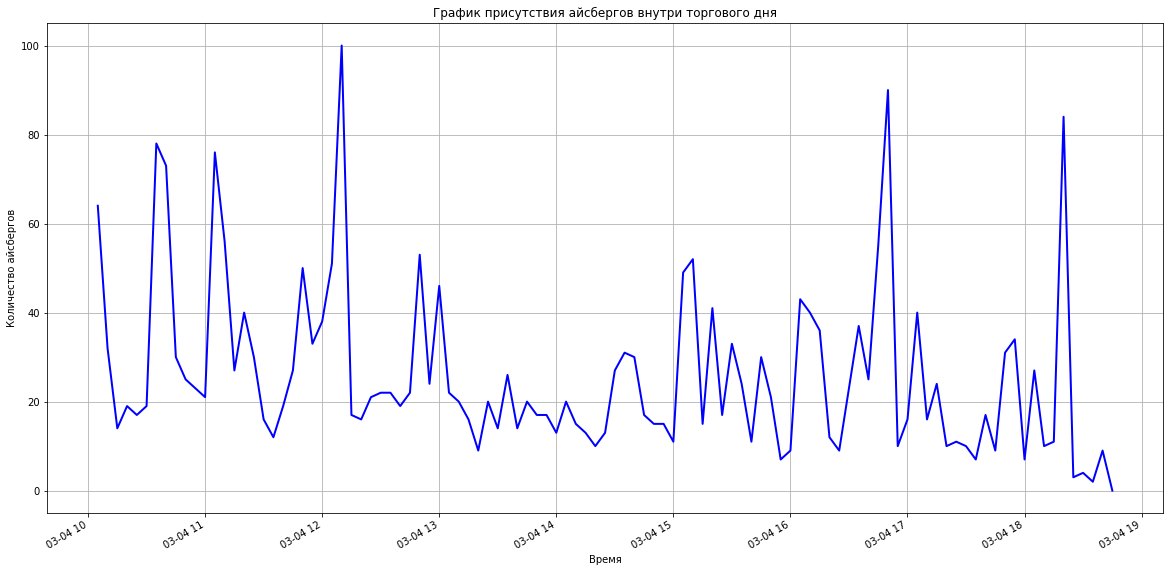

In [101]:
fig, ax = plt.subplots()
plt.grid()
plt.title('График присутствия айсбергов внутри торгового дня')
plt.xlabel('Время')
plt.ylabel('Количество айсбергов')
ax.plot(ice_life.TIME, ice_life.COUNT, linestyle = '-', linewidth = 2, color = 'blue', label = 'Количество айсбергов')
#ax.legend()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.gcf().autofmt_xdate()
plt.show()